Epoch 1/500, Generator Loss: 0.4895, Discriminator Loss: 0.4879
Epoch 1/500, Generator Loss: 0.4819, Discriminator Loss: 0.4672
Epoch 1/500, Generator Loss: 0.4689, Discriminator Loss: 0.4476
Epoch 1/500, Generator Loss: 0.4592, Discriminator Loss: 0.4343
Epoch 1/500, Generator Loss: 0.4524, Discriminator Loss: 0.4193
Epoch 1/500, Generator Loss: 0.4445, Discriminator Loss: 0.4083
Epoch 1/500, Generator Loss: 0.4359, Discriminator Loss: 0.3985
Epoch 1/500, Generator Loss: 0.4280, Discriminator Loss: 0.3913
Epoch 1/500, Generator Loss: 0.4221, Discriminator Loss: 0.3865
Epoch 1/500, Generator Loss: 0.4148, Discriminator Loss: 0.3803
Epoch 1/500, Generator Loss: 0.4075, Discriminator Loss: 0.3773
Epoch 1/500, Generator Loss: 0.4015, Discriminator Loss: 0.3763
Epoch 1/500, Generator Loss: 0.3961, Discriminator Loss: 0.3722
Epoch 1/500, Generator Loss: 0.3911, Discriminator Loss: 0.3675
Epoch 1/500, Generator Loss: 0.3873, Discriminator Loss: 0.3631
Epoch 1/500, Generator Loss: 0.3824, Dis

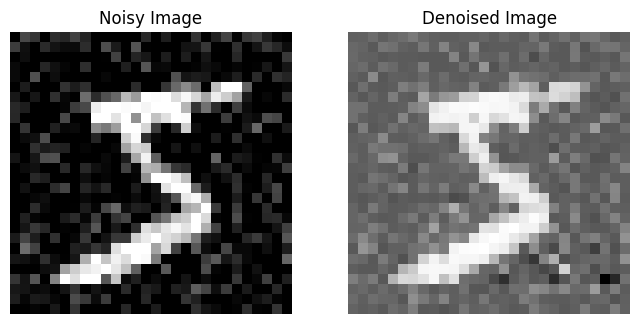

In [17]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv2D, BatchNormalization, LeakyReLU, Input, Conv2DTranspose, Add
from tensorflow.keras.models import Model

# Function to add noise to an image
def add_noise(image, noise_level=0.15):
    noise = np.random.normal(0, noise_level, image.shape)
    noisy_image = image + noise
    return np.clip(noisy_image, 0, 1)

# Load the clean MNIST dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Select a random image from the dataset
index = np.random.randint(0, x_train.shape[0])

# Clean image
clean_image = x_train[index] / 255.0

# Noisy image
noisy_image = add_noise(clean_image)

# Define the GAN, Generator, and Discriminator

# Function to build a convolutional residual block
def residual_block(x, filters, kernel_size=3):
    y = Conv2D(filters, kernel_size, padding='same')(x)
    y = BatchNormalization()(y)
    y = LeakyReLU(alpha=0.2)(y)
    y = Conv2D(filters, kernel_size, padding='same')(y)
    y = BatchNormalization()(y)
    return Add()([x, y])

# Generator model
def build_generator(input_shape=(28, 28, 1), num_residual_blocks=9):
    inputs = Input(shape=input_shape)

    # Initial convolutional layer with LeakyReLU activation
    x = Conv2D(32, (3, 3), activation="linear", padding='same')(inputs)
    x = LeakyReLU(alpha=0.1)(x)

    # Downsample with convolutional blocks
    for _ in range(3):
        x = Conv2D(64, 4, strides=1, padding='same')(x)
        x = BatchNormalization()(x)
        x = LeakyReLU(alpha=0.2)(x)

    # Residual blocks
    for _ in range(num_residual_blocks):
        x = residual_block(x, 64)

    # Upsample with transposed convolutional blocks
    for _ in range(3):
        x = Conv2DTranspose(64, 4, strides=1, padding='same')(x)
        x = BatchNormalization()(x)
        x = LeakyReLU(alpha=0.2)(x)

    # Output convolution
    outputs = Conv2D(1, 3, activation='tanh', padding='same')(x)

    return Model(inputs=inputs, outputs=outputs)

# PatchGAN Discriminator model
def build_patchgan_discriminator(input_shape=(28, 28, 1)):
    inputs = Input(shape=input_shape)

    x = Conv2D(64, (4, 4), strides=2, padding='same')(inputs)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2D(128, (4, 4), strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2D(256, (4, 4), strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2D(1, (4, 4), padding='same')(x)

    return Model(inputs=inputs, outputs=x)

# Create the PatchGAN model
def build_patchgan(generator_A, discriminator_A):
    input_A = Input(shape=generator_A.input.shape[1:])

    fake_A = generator_A(input_A)

    discriminator_A.trainable = False

    valid_A = discriminator_A(fake_A)

    return Model(inputs=input_A, outputs=[valid_A, fake_A])

# Train the PatchGAN to denoise MNIST data
def train_patchgan(generator_A, discriminator_A, noisy_data, clean_data, batch_size, epochs, generator_loss_threshold=0.15):
    patchgan_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

    for epoch in range(epochs):
        gen_losses = []
        disc_losses = []

        num_batches = len(noisy_data) // batch_size

        for batch in range(num_batches):
            batch_start = batch * batch_size
            batch_end = (batch + 1) * batch_size
            real_A = noisy_data[batch_start:batch_end]
            real_A = tf.convert_to_tensor(real_A, dtype=tf.float32)

            with tf.GradientTape(persistent=True) as tape:
                fake_A = generator_A(real_A, training=True)

                valid_A = discriminator_A(fake_A, training=True)

                loss_G = tf.reduce_mean(tf.abs(real_A - fake_A))
                loss_D_A = tf.reduce_mean(tf.square(valid_A))
                total_loss = loss_G + loss_D_A

            gradients = tape.gradient(total_loss, generator_A.trainable_variables)
            patchgan_optimizer.apply_gradients(zip(gradients, generator_A.trainable_variables))

            gen_losses.append(loss_G)
            disc_losses.append(loss_D_A)

            print(f"Epoch {epoch + 1}/{epochs}, Generator Loss: {tf.reduce_mean(gen_losses):.4f}, Discriminator Loss: {tf.reduce_mean(disc_losses):.4f}")

            if tf.reduce_mean(gen_losses) < generator_loss_threshold:
                print("Generator loss threshold reached. Stopping training.")
                break

    # Generate and print a noisy image and its denoised counterpart
    sample_noisy = noisy_data[0:1]
    sample_denoised = generator_A(sample_noisy, training=False)

    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.title("Noisy Image")
    plt.imshow(sample_noisy[0].reshape(28, 28), cmap='gray')

    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.title("Denoised Image")
    plt.imshow(sample_denoised[0].numpy().reshape(28, 28), cmap='gray')
    plt.axis('off')
    plt.show()

# Set hyperparameters
batch_size = 50
epochs_patchgan = 500

# Prepare data
num_samples = x_train.shape[0]
noisy_data = np.array([add_noise(image / 255.0) for image in x_train])
noisy_data = np.expand_dims(noisy_data, axis=-1)
clean_data = np.expand_dims(x_train / 255.0, axis=-1)

# Create and train the PatchGAN
generator_A = build_generator()
discriminator_A = build_patchgan_discriminator()  # Use PatchGAN discriminator

# Train the PatchGAN with generator loss threshold
train_patchgan(generator_A, discriminator_A, noisy_data, clean_data, batch_size, epochs_patchgan, generator_loss_threshold=0.15)


Epoch 1, Batch 1, Gen Loss: 0.8209, Disc Loss: 3.0024
Epoch 1, Batch 2, Gen Loss: 0.6531, Disc Loss: 1.6663
Epoch 1, Batch 3, Gen Loss: 0.2939, Disc Loss: 1.2227
Epoch 1, Batch 4, Gen Loss: 0.2708, Disc Loss: 1.0997
Epoch 1, Batch 5, Gen Loss: 0.2012, Disc Loss: 0.9254
Epoch 1, Batch 6, Gen Loss: 0.1526, Disc Loss: 0.8171
Epoch 1, Batch 7, Gen Loss: 0.1173, Disc Loss: 0.7573
Epoch 1, Batch 8, Gen Loss: 0.1062, Disc Loss: 0.7345
Epoch 1, Batch 9, Gen Loss: 0.0971, Disc Loss: 0.7015
Epoch 1, Batch 10, Gen Loss: 0.0838, Disc Loss: 0.5989
Epoch 1, Batch 11, Gen Loss: 0.0761, Disc Loss: 0.5848
Epoch 1, Batch 12, Gen Loss: 0.0689, Disc Loss: 0.6362
Epoch 1, Batch 13, Gen Loss: 0.0687, Disc Loss: 0.6350
Epoch 1, Batch 14, Gen Loss: 0.0609, Disc Loss: 0.5693
Epoch 1, Batch 15, Gen Loss: 0.0630, Disc Loss: 0.5744
Epoch 1, Batch 16, Gen Loss: 0.0591, Disc Loss: 0.5853
Epoch 1, Batch 17, Gen Loss: 0.0568, Disc Loss: 0.6101
Epoch 1, Batch 18, Gen Loss: 0.0529, Disc Loss: 0.5758
Epoch 1, Batch 19, 

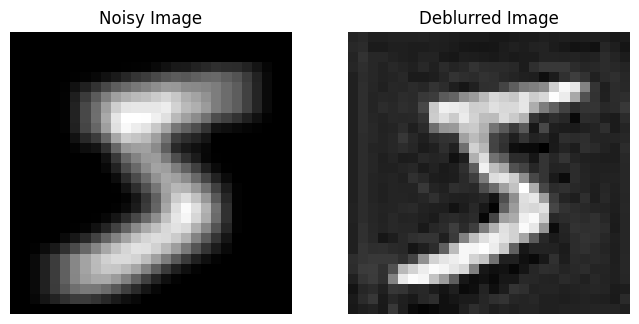

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv2D, BatchNormalization, LeakyReLU, Input, Conv2DTranspose
from tensorflow.keras.models import Model
import cv2

# Function to perform deblurring
def deblur_image(image, kernel_size=5):
    # Create a blurring kernel (e.g., Gaussian)
    kernel = np.ones((kernel_size, kernel_size)) / kernel_size**2
    deblurred_image = cv2.filter2D(image, -1, kernel)
    return deblurred_image

# Load the clean MNIST dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Select a random image from the dataset
index = np.random.randint(0, x_train.shape[0])

# Clean image
clean_image = x_train[index] / 255.0

# Blurred image
blurred_image = deblur_image(clean_image)

# Define the Deblur GAN, Generator, and Discriminator

# Generator model for deblurring
def build_deblur_generator(input_shape=(28, 28, 1)):
    inputs = Input(shape=input_shape)

    # Deblurring layers (replace with your desired architecture)
    x = Conv2D(64, (3, 3), activation="relu", padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Conv2D(64, (3, 3), activation="relu", padding='same')(x)
    x = BatchNormalization()(x)

    # Upsample with transposed convolutional blocks
    x = Conv2DTranspose(64, 4, strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    # Output convolution
    outputs = Conv2D(1, 3, activation='linear', padding='same')(x)

    return Model(inputs=inputs, outputs=outputs)

# Create a PatchGAN Discriminator for deblurred images (you can customize this)
def build_deblur_discriminator(input_shape=(28, 28, 1)):
    inputs = Input(shape=input_shape)

    x = Conv2D(64, (4, 4), strides=2, padding='same')(inputs)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2D(128, (4, 4), strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2D(256, (4, 4), strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2D(1, (4, 4), padding='same')(x)

    return Model(inputs=inputs, outputs=x)

# Train the Deblur GAN with early stopping based on generator loss
def train_deblur_gan(generator, discriminator, blurred_data, clean_data, batch_size, max_epochs, generator_loss_threshold=0.0050):
    # Define loss functions (you may need to adjust these)
    loss_fn = tf.keras.losses.MeanSquaredError()

    generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
    discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

    epoch = 0  # Initialize the epoch counter

    while epoch < max_epochs:  # Continue until the maximum number of epochs is reached
        for i in range(0, len(blurred_data), batch_size):
            batch_blurred = blurred_data[i:i + batch_size]
            batch_clean = clean_data[i:i + batch_size]

            with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
                # Generate deblurred images
                generated_images = generator(batch_blurred, training=True)

                # Discriminator loss (adversarial)
                real_output = discriminator(batch_clean, training=True)
                fake_output = discriminator(generated_images, training=True)
                disc_loss = loss_fn(real_output, tf.ones_like(real_output)) + loss_fn(fake_output, tf.zeros_like(fake_output))

                # Generator loss
                gen_loss = loss_fn(batch_clean, generated_images)

            gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
            gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

            generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
            discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

            print(f"Epoch {epoch + 1}, Batch {i//batch_size + 1}, Gen Loss: {gen_loss:.4f}, Disc Loss: {disc_loss:.4f}")

            if gen_loss < generator_loss_threshold:
                print(f"Generator loss threshold ({generator_loss_threshold}) reached. Stopping training.")
                break  # Exit the training loop

        epoch += 1  # Move to the next epoch

    # Generate and display a noisy image alongside its denoised counterpart
    sample_blurred = blurred_data[0:1]
    sample_deblurred = generator(sample_blurred, training=False)

    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.title("Noisy Image")
    plt.imshow(sample_blurred[0].reshape(28, 28), cmap='gray')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title("Deblurred Image")
    plt.imshow(sample_deblurred[0].numpy().reshape(28, 28), cmap='gray')
    plt.axis('off')
    plt.show()

# Set hyperparameters
batch_size = 32
max_epochs_deblur_gan = 200  # Maximum number of epochs
generator_loss_threshold = 0.0050  # Generator loss threshold

# Prepare data
num_samples = x_train.shape[0]
blurred_data = np.array([deblur_image(image / 255.0) for image in x_train])
blurred_data = np.expand_dims(blurred_data, axis=-1)
clean_data = np.expand_dims(x_train / 255.0, axis=-1)

# Create and train the Deblur GAN with early stopping
deblur_generator = build_deblur_generator()
deblur_discriminator = build_deblur_discriminator()

# Train the Deblur GAN
train_deblur_gan(deblur_generator, deblur_discriminator, blurred_data, clean_data, batch_size, max_epochs_deblur_gan, generator_loss_threshold)


Streaming output truncated to the last 5000 lines.
Epoch 2501, Batch 1, Gen Loss: 0.0007, Disc Loss: 0.0012
Generator loss threshold (0.005) reached. Stopping training.
Epoch 2502, Batch 1, Gen Loss: 0.0007, Disc Loss: 0.0014
Generator loss threshold (0.005) reached. Stopping training.
Epoch 2503, Batch 1, Gen Loss: 0.0007, Disc Loss: 0.0013
Generator loss threshold (0.005) reached. Stopping training.
Epoch 2504, Batch 1, Gen Loss: 0.0007, Disc Loss: 0.0014
Generator loss threshold (0.005) reached. Stopping training.
Epoch 2505, Batch 1, Gen Loss: 0.0008, Disc Loss: 0.0012
Generator loss threshold (0.005) reached. Stopping training.
Epoch 2506, Batch 1, Gen Loss: 0.0008, Disc Loss: 0.0013
Generator loss threshold (0.005) reached. Stopping training.
Epoch 2507, Batch 1, Gen Loss: 0.0008, Disc Loss: 0.0012
Generator loss threshold (0.005) reached. Stopping training.
Epoch 2508, Batch 1, Gen Loss: 0.0008, Disc Loss: 0.0015
Generator loss threshold (0.005) reached. Stopping training.
Epoch

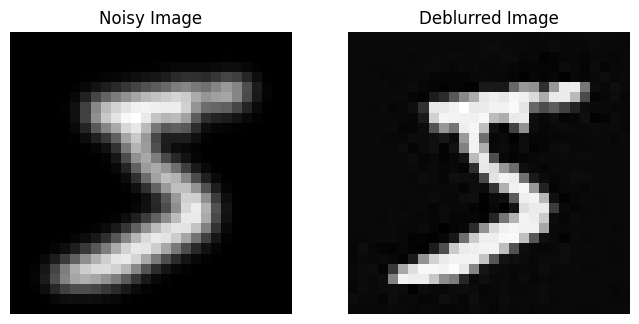

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv2D, BatchNormalization, LeakyReLU, Input, Conv2DTranspose
from tensorflow.keras.models import Model
import cv2

# Function to perform Gaussian blurring
def gaussian_blur(image, sigma=1):
    return cv2.GaussianBlur(image, (0, 0), sigma)

# Load the clean MNIST dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Select a random image from the dataset
index = np.random.randint(0, x_train.shape[0])

# Clean image
clean_image = x_train[index] / 255.0

# Blurred image with Gaussian blur
blurred_image = gaussian_blur(clean_image)

# Define the Deblur GAN, Generator, and Discriminator

# Generator model for deblurring
def build_deblur_generator(input_shape=(28, 28, 1)):
    inputs = Input(shape=input_shape)

    # Deblurring layers (replace with your desired architecture)
    x = Conv2D(64, (3, 3), activation="relu", padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Conv2D(64, (3, 3), activation="relu", padding='same')(x)
    x = BatchNormalization()(x)

    # Upsample with transposed convolutional blocks
    x = Conv2DTranspose(64, 4, strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    # Output convolution
    outputs = Conv2D(1, 3, activation='linear', padding='same')(x)

    return Model(inputs=inputs, outputs=outputs)

# Create a PatchGAN Discriminator for deblurred images (you can customize this)
def build_deblur_discriminator(input_shape=(28, 28, 1)):
    inputs = Input(shape=input_shape)

    x = Conv2D(64, (4, 4), strides=2, padding='same')(inputs)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2D(128, (4, 4), strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2D(256, (4, 4), strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2D(1, (4, 4), padding='same')(x)

    return Model(inputs=inputs, outputs=x)

# Train the Deblur GAN with early stopping based on generator loss
def train_deblur_gan(generator, discriminator, blurred_data, clean_data, batch_size, max_epochs, generator_loss_threshold=0.0050):
    # Define loss functions (you may need to adjust these)
    loss_fn = tf.keras.losses.MeanSquaredError()

    generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
    discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

    epoch = 0  # Initialize the epoch counter

    while epoch < max_epochs:  # Continue until the maximum number of epochs is reached
        for i in range(0, len(blurred_data), batch_size):
            batch_blurred = blurred_data[i:i + batch_size]
            batch_clean = clean_data[i:i + batch_size]

            with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
                # Generate deblurred images
                generated_images = generator(batch_blurred, training=True)

                # Discriminator loss (adversarial)
                real_output = discriminator(batch_clean, training=True)
                fake_output = discriminator(generated_images, training=True)
                disc_loss = loss_fn(real_output, tf.ones_like(real_output)) + loss_fn(fake_output, tf.zeros_like(fake_output))

                # Generator loss
                gen_loss = loss_fn(batch_clean, generated_images)

            gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
            gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

            generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
            discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

            print(f"Epoch {epoch + 1}, Batch {i//batch_size + 1}, Gen Loss: {gen_loss:.4f}, Disc Loss: {disc_loss:.4f}")

            if gen_loss < generator_loss_threshold:
                print(f"Generator loss threshold ({generator_loss_threshold}) reached. Stopping training.")
                break  # Exit the training loop

        epoch += 1  # Move to the next epoch

    # Generate and display a noisy image alongside its denoised counterpart
    sample_blurred = blurred_data[0:1]
    sample_deblurred = generator(sample_blurred, training=False)

    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.title("Noisy Image")
    plt.imshow(sample_blurred[0].reshape(28, 28), cmap='gray')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title("Deblurred Image")
    plt.imshow(sample_deblurred[0].numpy().reshape(28, 28), cmap='gray')
    plt.axis('off')
    plt.show()

# Set hyperparameters
batch_size = 32
max_epochs_deblur_gan = 5000  # Maximum number of epochs
generator_loss_threshold = 0.0050  # Generator loss threshold

# Prepare data
num_samples = x_train.shape[0]
blurred_data = np.array([gaussian_blur(image / 255.0) for image in x_train])
blurred_data = np.expand_dims(blurred_data, axis=-1)
clean_data = np.expand_dims(x_train / 255.0, axis=-1)

# Create and train the Deblur GAN with early stopping
deblur_generator = build_deblur_generator()
deblur_discriminator = build_deblur_discriminator()

# Train the Deblur GAN
train_deblur_gan(deblur_generator, deblur_discriminator, blurred_data, clean_data, batch_size, max_epochs_deblur_gan, generator_loss_threshold)

In [18]:


pip install tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 12.5 MB/s eta 0:00:00


In [19]:
import cv2
import numpy as np
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

def main():
    # Load the original image
    original_image = cv2.imread('original_image.jpg')

    # Apply blur to the original image
    blurred_image = cv2.GaussianBlur(original_image, (5, 5), 0)

    # Apply deblurring
    deblurred_photo = sample_deblurred[0].numpy().reshape(28, 28)

    # Print the original, blurred, and deblurred images
    cv2.imshow('Original Image', original_image)
    cv2.imshow('Blurred Image', blurred_image)
    cv2.imshow('Deblurred Image', deblurred_image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

    # Calculate PSNR and SSIM
    psnr_blurred = peak_signal_noise_ratio(original_image, blurred_image)
    ssim_blurred = structural_similarity(original_image, blurred_image, multichannel=True)
    psnr_deblurred = peak_signal_noise_ratio(original_image, deblurred_image)
    ssim_deblurred = structural_similarity(original_image, deblurred_image, multichannel=True)

    # Print PSNR and SSIM values
    print("PSNR (Original vs. Blurred):", psnr_blurred)
    print("SSIM (Original vs. Blurred):", ssim_blurred)
    print("PSNR (Original vs. Deblurred):", psnr_deblurred)
    print("SSIM (Original vs. Deblurred):", ssim_deblurred)

if __name__ == '__main__':
    main()

error: OpenCV(4.8.0) /io/opencv/modules/imgproc/src/smooth.dispatch.cpp:617: error: (-215:Assertion failed) !_src.empty() in function 'GaussianBlur'


In [ ]:
pip install scikit-image


Original vs Blurred PSNR: 18.63
Original vs Blurred SSIM: 0.8760
Original vs Deblurred PSNR: 30.83
Original vs Deblurred SSIM: 0.9888


<ipython-input-21-1901c6e985f5>:6: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr_value = psnr(original, distorted)


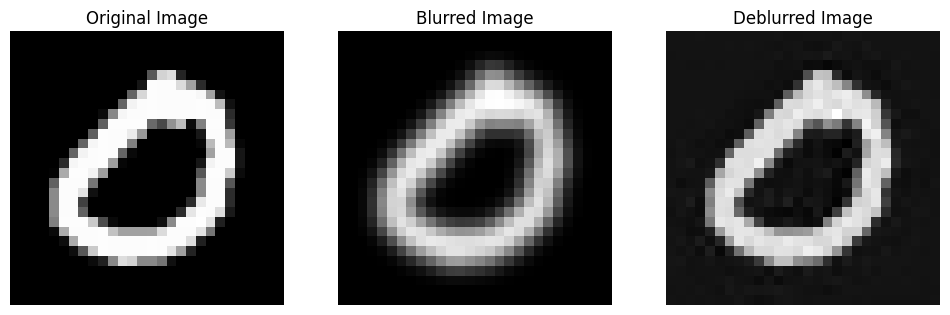

In [ ]:
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

# Function to calculate PSNR and SSIM
def calculate_metrics(original, distorted, title):
    psnr_value = psnr(original, distorted)
    ssim_value = ssim(original, distorted, data_range=original.max() - original.min())

    print(f"{title} PSNR: {psnr_value:.2f}")
    print(f"{title} SSIM: {ssim_value:.4f}")

# Original image
original_image = x_train[index] / 255.0

# Calculate PSNR and SSIM between original and blurred image
calculate_metrics(original_image, blurred_image, "Original vs Blurred")

# Generate and display a deblurred image
sample_deblurred = deblur_generator(np.expand_dims(blurred_image, axis=0), training=False).numpy().reshape(28, 28)

# Calculate PSNR and SSIM between original and deblurred image
calculate_metrics(original_image, sample_deblurred, "Original vs Deblurred")
plt.figure(figsize=(12, 4))

# Original image
plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(original_image, cmap='gray')
plt.axis('off')

# Blurred image
plt.subplot(1, 3, 2)
plt.title("Blurred Image")
plt.imshow(blurred_image, cmap='gray')
plt.axis('off')

# Deblurred image
plt.subplot(1, 3, 3)
plt.title("Deblurred Image")
plt.imshow(sample_deblurred, cmap='gray')
plt.axis('off')

plt.show()


Enter expected grade for MAE: B
Enter expected grade for CN: B+
Enter expected grade for DEPARTMENT ELECTIVE WITH LAB: B
Enter expected grade for DEPARTMENT ELECTIVE WITHOUT LAB: B
Enter expected grade for OPEN ELECTIVE 1: B
Enter expected grade for OPEN ELECTIVE 2: B
Enter expected grade for SUMMER INTERNSHIP: A
Enter expected grade for MINOR PROJECT: A
Your CGPA is: 7.39


''